In [13]:
import spanningTreeModule as tree
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt

In [21]:
graphToConsider = ig.Graph.Famous('Grotzsch')
spanningTreeDict = tree.generateSpanningTreeDict(graphToConsider)
spanningTreeDict

{0: [((0, 7),
   (1, 3),
   (1, 6),
   (2, 4),
   (2, 6),
   (2, 8),
   (3, 10),
   (4, 9),
   (5, 7),
   (5, 8)),
 1: [((0, 1),
   (0, 2),
   (1, 9),
   (2, 6),
   (2, 8),
   (3, 4),
   (3, 10),
   (5, 7),
   (5, 9),
   (5, 10)),
 2: [((0, 1),
   (1, 3),
   (1, 9),
   (2, 4),
   (2, 8),
   (3, 10),
   (4, 7),
   (5, 6),
   (5, 8),
   (5, 10)),
 3: [((0, 1),
   (0, 7),
   (1, 6),
   (1, 9),
   (2, 6),
   (3, 4),
   (3, 8),
   (3, 10),
   (5, 7),
   (5, 10)),
 4: [((0, 7),
   (1, 3),
   (1, 6),
   (1, 9),
   (2, 4),
   (2, 8),
   (3, 8),
   (4, 7),
   (5, 8),
   (5, 10)),
 5: [((0, 1),
   (0, 2),
   (0, 10),
   (1, 3),
   (2, 6),
   (3, 8),
   (4, 7),
   (4, 9),
   (5, 8),
   (5, 9)),
 6: [((0, 2),
   (1, 3),
   (1, 9),
   (2, 4),
   (2, 8),
   (3, 4),
   (3, 10),
   (4, 7),
   (5, 6),
   (5, 10)),
 7: [((0, 1),
   (0, 2),
   (0, 10),
   (1, 3),
   (2, 8),
   (3, 4),
   (4, 7),
   (4, 9),
   (5, 6),
   (5, 7)),
 8: [((0, 7),
   (0, 10),
   (1, 6),
   (1, 9),
   (2, 6),
   (3, 8),
   (3,

In [23]:
metaGraphComplete, metaGraphGreedy, errorDict = tree.treeSetToMultipleMetaGraphs(spanningTreeDict, chromaticNumber=4, graph=graphToConsider)

In [16]:
# fig, ax = plt.subplots()
# layout = metaGraphComplete.layout_graphopt()
# ig.plot(metaGraphComplete, target = ax, layout = layout, vertex_color = [vertex.eccentricity()*20 for vertex in metaGraphComplete.vs])

In [24]:
print(sum(1 for value in errorDict.values() if value == 0))


666


7.0
28


[35, 38, 159, 268, 295, 335, 379, 483, 511, 518, 528, 570, 574, 583, 707, 740, 766, 806, 843, 855, 858, 862, 864, 890, 910, 960, 973, 1024, 1034, 1068, 1075, 1079, 1094, 1099, 1112, 1119, 1185, 1205, 1277, 1317, 1327, 1415, 1492, 1501, 1506, 1507, 1523, 1524, 1530, 1532, 1540, 1569, 1583, 1602, 1611, 1616, 1698, 1732, 1760, 1798, 1828, 1863, 1917, 1941, 2050, 2072, 2146, 2161, 2176, 2246, 2262, 2301, 2307, 2359, 2439, 2479, 2511, 2573, 2660, 2688, 2729, 2811, 2854, 2873, 2939, 2941, 2972, 3007, 3019, 3038, 3054, 3113, 3125, 3127, 3177, 3204, 3218, 3313, 3319, 3348, 3350, 3379, 3403, 3461, 3473, 3475, 3504, 3516, 3527, 3590, 3663, 3695, 3711, 3800, 3803, 3817, 3866, 3932, 3955, 3974, 3984, 4030, 4040, 4042, 4064, 4076, 4255, 4256, 4263, 4281, 4399, 4405, 4415, 4417, 4419, 4429, 4453, 4457, 4462, 4486, 4515, 4571, 4584, 4648, 4679, 4739, 4860, 4903, 4929, 4933, 5058, 5090, 5161, 5177, 5201, 5261, 5335, 5371, 5391, 5531, 5546, 5615, 5617, 5622, 5623, 5648, 5649, 5668, 5693, 5713, 5727, 57

(array([  666.,  3808.,  9690., 13126.,  8742.,  2240.,   342.,    28.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <BarContainer object of 8 artists>)

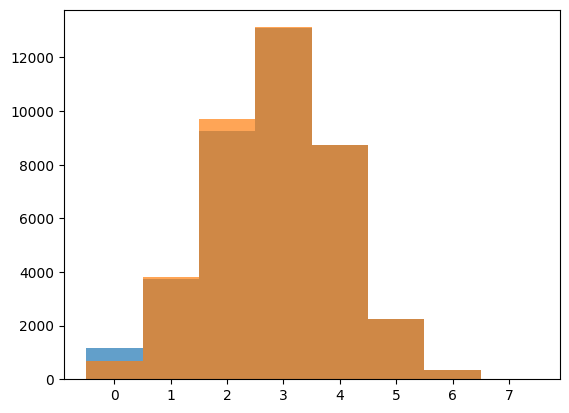

In [25]:
maximum = max(metaGraphGreedy.vs.eccentricity())
print(maximum)
print(sum(1 for value in metaGraphGreedy.vs.eccentricity() if value == maximum))

localMinimumIndices = [vertex.index for vertex in metaGraphGreedy.vs if vertex.eccentricity() == 0]
print(localMinimumIndices)
globalMinimumIndices = [key for key in errorDict.keys() if errorDict[key] == 0]
print(globalMinimumIndices)

plt.hist(metaGraphGreedy.vs.eccentricity(), bins=np.arange(-0.5, max(metaGraphGreedy.vs.eccentricity()) + 1.5, 1), alpha = 0.7)
plt.hist(errorDict.values(), bins=np.arange(-0.5, max(errorDict.values())+1.5, 1), alpha = 0.7)